# MLP

Use MLP of size 256, 128, 64 and relu activation. 

Use Splitter2. Use one z-score.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 10:49:01.910991
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

ALPHABET_SIZE=4
K=4
VOCABULARY_SIZE = ALPHABET_SIZE**K 
from TrainValidSplit2 import Splitter2
EPOCHS=10
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    act='relu'
    dense1_layer = keras.layers.Dense(4, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(4, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(2, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation='sigmoid',dtype=dt)

    # Is this a joke?
    dense1_layer = keras.layers.Dense(1, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)

    mlp = keras.models.Sequential()
    mlp.add(dense1_layer)
    #mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes,'one_z')
        X_train,y_train = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)

        fold += 1
        print('Fold',fold)
        print('Thresholds',thresholds)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Train and validate

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 10:49:16.914432
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 10:49:21.618286


In [8]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 10:49:21.637651
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 259


2022-10-20 10:49:21.746689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trainable params: 259
Non-trainable params: 0
_________________________________________________________________
None


Cross valiation
2022-10-20 10:49:22.096177
Fold 1
Thresholds (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
376/376 [==============================] - 5s 9ms/step - loss: 0.5861 - accuracy: 0.7040 - val_loss: 0.5041 - val_accuracy: 0.8233
Epoch 2/10
376/376 [==============================] - 2s 5ms/step - loss: 0.4729 - accuracy: 0.8158 - val_loss: 0.4351 - val_accuracy: 0.8501
Epoch 3/10
376/376 [==============================] - 2s 6ms/step - loss: 0.4274 - accuracy: 0.8404 - val_loss: 0.3961 - val_accuracy: 0.8608
Epoch 4/10
376/376 [==============================] - 2s 5ms/step - loss: 0.3992 - accuracy: 0.8509 - val_loss: 0.3784 - val_accuracy: 0.8619
Epoch 5/10
376/376 [==============================] - 3s 7ms/step - loss: 0.3836 - accuracy: 0.8551 - val_loss: 0.3690 - val_accuracy: 0.8619
Epoch 6/10
376/376 [==============================] - 2s 6ms/step - loss: 0.3731 - a

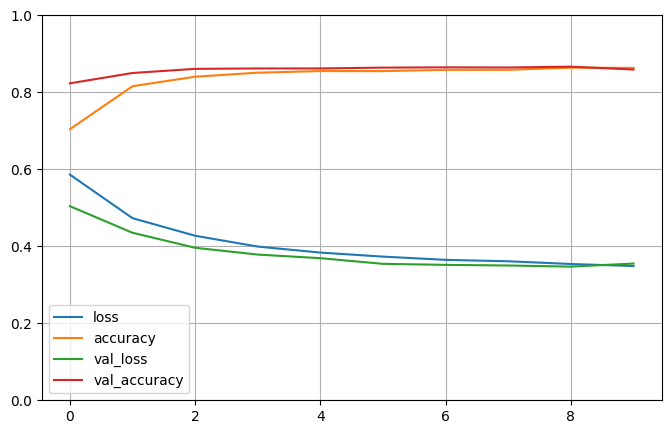

accuracy: 85.90%
Fold 2
Thresholds (-1.240869517441693, 1.1382361428048027)
Train set ones/size 5507 / 12068
Valid set ones/size 1385 / 3092
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
378/378 [==============================] - 4s 8ms/step - loss: 0.6543 - accuracy: 0.5897 - val_loss: 0.5986 - val_accuracy: 0.7607
Epoch 2/10
378/378 [==============================] - 3s 8ms/step - loss: 0.5341 - accuracy: 0.7641 - val_loss: 0.5102 - val_accuracy: 0.7561
Epoch 3/10
378/378 [==============================] - 3s 8ms/step - loss: 0.4824 - accuracy: 0.7961 - val_loss: 0.4800 - val_accuracy: 0.7817
Epoch 4/10
378/378 [==============================] - 3s 7ms/step - loss: 0.4407 - accuracy: 0.8171 - val_loss: 0.4900 - val_accuracy: 0.7526
Epoch 5/10
378/378 [==============================] - 5s 13ms/step - loss: 0.4183 - accuracy: 0.8283 - val_loss: 0.4385 - val_accuracy: 0.8092
Epoch 6/10
378/378 [==============================] - 2s 6ms/step - loss: 0.3952 - accuracy: 0.8428 - val_los

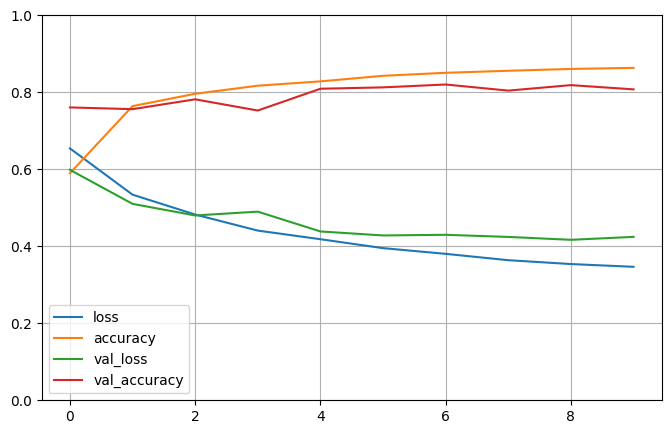

accuracy: 80.76%
Fold 3
Thresholds (-1.2410877135068596, 1.138897086169583)
Train set ones/size 5507 / 11991
Valid set ones/size 1384 / 3166
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
375/375 [==============================] - 4s 8ms/step - loss: 0.5866 - accuracy: 0.7210 - val_loss: 0.6247 - val_accuracy: 0.6027
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4966 - accuracy: 0.7814 - val_loss: 0.6005 - val_accuracy: 0.8225
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.4420 - accuracy: 0.8120 - val_loss: 0.5351 - val_accuracy: 0.8086
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.4149 - accuracy: 0.8245 - val_loss: 0.5474 - val_accuracy: 0.8421
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3995 - accuracy: 0.8337 - val_loss: 0.5019 - val_accuracy: 0.8020
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3807 - accuracy: 0.8461 - val_los

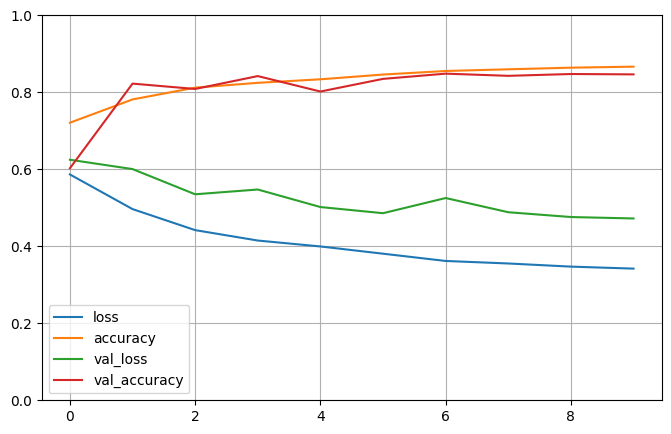

accuracy: 84.65%
Fold 4
Thresholds (-1.244761137161994, 1.149166980863346)
Train set ones/size 5557 / 12235
Valid set ones/size 1240 / 2805
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
383/383 [==============================] - 3s 6ms/step - loss: 0.7067 - accuracy: 0.5313 - val_loss: 0.6865 - val_accuracy: 0.5579
Epoch 2/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6888 - accuracy: 0.5458 - val_loss: 0.6841 - val_accuracy: 0.5579
Epoch 3/10
383/383 [==============================] - 2s 5ms/step - loss: 0.6478 - accuracy: 0.5435 - val_loss: 0.6324 - val_accuracy: 0.5715
Epoch 4/10
383/383 [==============================] - 2s 6ms/step - loss: 0.5168 - accuracy: 0.7660 - val_loss: 0.5689 - val_accuracy: 0.8303
Epoch 5/10
383/383 [==============================] - 2s 5ms/step - loss: 0.4611 - accuracy: 0.8035 - val_loss: 0.5005 - val_accuracy: 0.8317
Epoch 6/10
383/383 [==============================] - 2s 5ms/step - loss: 0.4172 - accuracy: 0.8308 - val_loss:

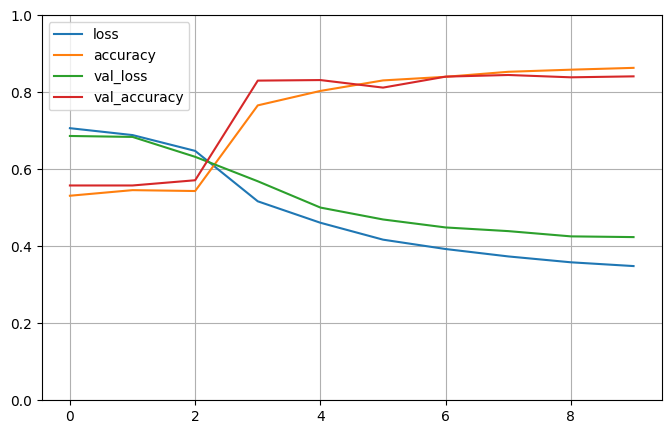

accuracy: 84.14%
Fold 5
Thresholds (-1.226430673293863, 1.1381054621929456)
Train set ones/size 5457 / 12030
Valid set ones/size 1435 / 3209
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
376/376 [==============================] - 3s 5ms/step - loss: 0.7032 - accuracy: 0.5462 - val_loss: 0.6873 - val_accuracy: 0.5575
Epoch 2/10
376/376 [==============================] - 2s 6ms/step - loss: 0.6729 - accuracy: 0.6121 - val_loss: 0.6706 - val_accuracy: 0.6469
Epoch 3/10
376/376 [==============================] - 2s 5ms/step - loss: 0.6233 - accuracy: 0.7182 - val_loss: 0.6015 - val_accuracy: 0.7853
Epoch 4/10
376/376 [==============================] - 2s 5ms/step - loss: 0.5732 - accuracy: 0.7616 - val_loss: 0.5797 - val_accuracy: 0.7766
Epoch 5/10
376/376 [==============================] - 2s 6ms/step - loss: 0.5479 - accuracy: 0.7828 - val_loss: 0.5719 - val_accuracy: 0.7956
Epoch 6/10
376/376 [==============================] - 2s 6ms/step - loss: 0.5134 - accuracy: 0.8042 - val_loss

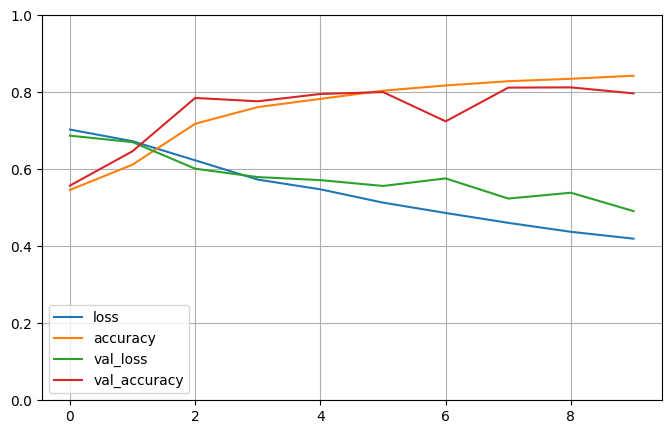

accuracy: 79.71%

Validation core mean 83.03% (+/- 2.38%)
2022-10-20 10:51:38.029080


In [9]:
# Train
print ("Cross valiation")
print(datetime.now())
do_cross_validation(splitter,EPOCHS)
print(datetime.now())